#  English sequence generator 

**Creating an English language sequence generator capable of building semi-coherent English sentences from scratch by building them up character-by-character**

**Natural Language Processing**

Dataset:  Complete version of Sir Arthur Conan Doyle's classic book The Adventures of Sherlock Holmes

Based on [RNN project: text generation](https://github.com/udacity/aind2-rnn) of the [Udacity's Artificial Intelligence  Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889)

In [1]:
%matplotlib inline

import os, sys
import numpy as np
import seaborn as sns

sys.path.append("../")
import ds_boost
import keras


ds_boost.set_parent_execution_path()
ds_boost.info_system()
ds_boost.reproducible(seed=9)
sns.set()

Path changed to /home/angel/DRIVE/data-science-keras

HARDWARE:
CPU:	Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
RAM:	8 GB
GPU:	NVIDIA GeForce RTX 2070

OS:	Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.35

ENV:	/home/angel/miniconda3/envs/gpu

PYTHON:	3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
tensorflow                    2.9.1
pandas                        1.4.3
numpy                        1.23.1

EXECUTION PATH: /home/angel/DRIVE/data-science-keras
EXECUTION DATE: Mon Aug 15 17:39:23 2022


## Load and Process the data

In [2]:
text = open("data/holmes.txt").read().lower()
print("Total characters: {}".format(len(text)))
text[:300]

Total characters: 581864


"\ufeffproject gutenberg's the adventures of sherlock holmes, by arthur conan doyle\n\nthis ebook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  you may copy it, give it away or\nre-use it under the terms of the project gutenberg license included\nwith this ebook or "

### Preprocess the data

In [3]:
text = text[1302:]  # remove title, author page, and table of contents
text = text.replace("\n", " ")
text = text.replace("\r", " ")

unique_characters = set(list(text))
print(unique_characters)

{'j', '&', ')', '!', 'o', '3', '*', 'f', 'm', '2', 'z', '0', 'd', 'é', 'â', '$', 's', '9', 'è', 'b', ';', 'i', 'h', 't', 'n', '/', '"', '?', 'à', '@', '.', '1', '6', 'y', 'e', 'c', 'r', 'l', 'k', 'g', 'v', 'w', ',', '5', ' ', '7', 'p', ':', '8', '%', 'x', '4', '(', 'q', '-', 'u', 'a', "'"}


In [4]:
# remove non-english characters
import re

text = re.sub("[$%&'()*@/àâèé0123456789-]", " ", text)
text = text.replace('"', " ")
text = text.replace("  ", " ")  # shorten any extra dead space created above
text[:300]

'is eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler. all emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. he was, i take it, the most perfect reasoning and observing machine '

In [5]:
chars = sorted(list(set(text)))
num_chars = len(chars)
print("Total characters: {}".format(len(text)))
print("Unique characters: {}".format(num_chars))
print(chars)

Total characters: 573681
Unique characters: 33
[' ', '!', ',', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Split data into input/output pairs

In [6]:
# Transforms the input text and window-size into a set of input/output pairs
#  for use with the RNN """

window_size = 100
step_size = 5

input_pairs = []
output_pairs = []

for i in range(0, len(text) - window_size, step_size):
    input_pairs.append(text[i : i + window_size])
    output_pairs.append(text[i + window_size])

### One-hot encoding characters

In [7]:
chars_to_indices = dict((c, i) for i, c in enumerate(chars))
indices_to_chars = dict((i, c) for i, c in enumerate(chars))

# create variables for one-hot encoded input/output
X = np.zeros((len(input_pairs), window_size, num_chars), dtype=bool)
y = np.zeros((len(input_pairs), num_chars), dtype=bool)

# transform character-based input_pairs/output_pairs into equivalent numerical versions
for i, sentence in enumerate(input_pairs):
    for t, char in enumerate(sentence):
        X[i, t, chars_to_indices[char]] = 1
    y[i, chars_to_indices[output_pairs[i]]] = 1

## Recurrent Neural Network Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               187200    
                                                                 
 dense (Dense)               (None, 33)                6633      
                                                                 
 dense_1 (Dense)             (None, 33)                1122      
                                                                 
Total params: 194,955
Trainable params: 194,955
Non-trainable params: 0
_________________________________________________________________
Training ... (this may take a while)
CPU times: user 10min 22s, sys: 3min 59s, total: 14min 22s
Wall time: 12min 26s


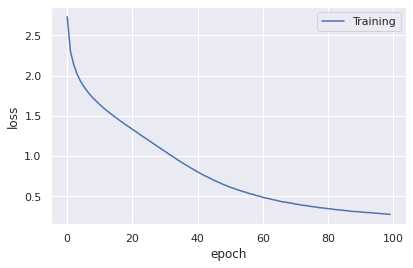


Training loss:  	0.2738

Model saved at models/text_generator.h5


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM

model = Sequential()
model.add(LSTM(200, input_shape=(window_size, num_chars)))
model.add(Dense(num_chars, activation=None))
model.add(Dense(num_chars, activation="softmax"))
model.summary()

optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss="categorical_crossentropy", optimizer=optimizer)

# train the model
print("Training ... (this may take a while)")
%time history = model.fit(X, y, batch_size=512, epochs=100,verbose=0)
ds_boost.show_training(history)

model_path = os.path.join("models", "text_generator.h5")
model.save(model_path)
print("\nModel saved at", model_path)

### Make predictions

In [9]:
model = keras.models.load_model(model_path)
print("Model loaded:", model_path)


def predict_next_chars(model, input_chars, num_to_predict):
    """predict a number of future characters"""

    predicted_chars = ""
    for i in range(num_to_predict):
        x_test = np.zeros((1, window_size, len(chars)))
        for t, char in enumerate(input_chars):
            x_test[0, t, chars_to_indices[char]] = 1.0

        test_predict = model.predict(x_test, verbose=0)[0]

        # translate numerical prediction back to characters
        r = np.argmax(test_predict)
        d = indices_to_chars[r]

        # update predicted_chars and input
        predicted_chars += d
        input_chars += d
        input_chars = input_chars[1:]
    return predicted_chars


for s in range(0, 500, 100):
    start_index = s
    input_chars = text[start_index : start_index + window_size]
    predict_input = predict_next_chars(model, input_chars, num_to_predict=100)

    print("------------------")
    input_line = "input chars = " + "\n" + input_chars + '"' + "\n"
    print(input_line)

    line = "predicted chars = " + "\n" + predict_input + '"' + "\n"
    print(line)

Model loaded: models/text_generator.h5
------------------
input chars = 
is eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin"

predicted chars = 
 the lock which would givis down anroring a crifts is nobbony that is all the kinting of off countly"

------------------
input chars = 
 to love for irene adler. all emotions, and that one particularly, were abhorrent to his cold, preci"

predicted chars = 
se.  yes. the ereprices and to conse that i shall ret the fact of hose. i charmed it was the slut of"

------------------
input chars = 
se but admirably balanced mind. he was, i take it, the most perfect reasoning and observing machine "

predicted chars = 
so id. it is a que, and mr. wits half cer us, is she threatemed to lately you will find the other. i"

------------------
input chars = 
that the world has seen, but as a lover he would have placed himself in a false position. he never s"

predicted chars = 
peck partion.  seet i nett t